In [46]:

%pip install --user -U nltk
%pip install -U scikit-learn
%pip install beautifulsoup4
%pip install seaborn
%pip install wordcloud


^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split     
from nltk.tokenize import ToktokTokenizer    
from nltk.stem import WordNetLemmatizer
import string
from bs4 import BeautifulSoup     
from nltk.tokenize import word_tokenize    
from nltk.corpus import stopwords 
import re            
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,precision_score, f1_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\papal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# stopwords

<WordListCorpusReader in 'C:\\Users\\papal\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>

In [60]:
df = pd.read_csv("./data/TwitterRenamed.csv")

In [61]:
df.shape

(1048572, 7)

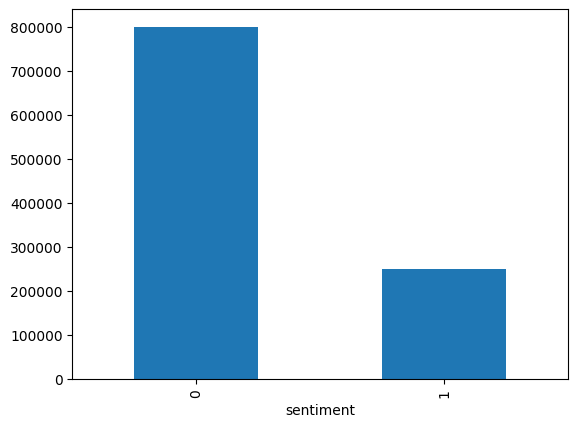

In [17]:
df.groupby(['sentiment'])['sentiment'].count().plot(kind='bar')
plt.savefig('Classes.png')

In [24]:
df['Tamanho dos comentários'] = df['review'].apply(len)

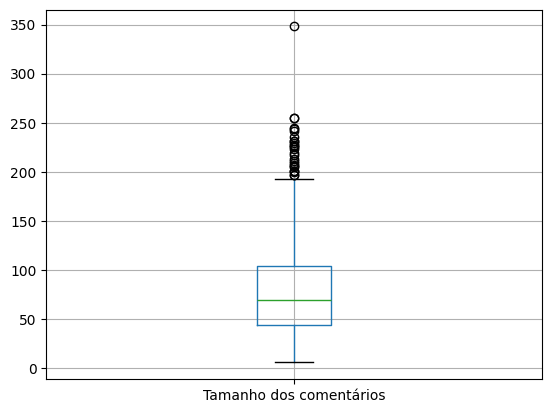

In [26]:
df.boxplot(column=['Tamanho dos comentários'])
plt.savefig("comentários.png")

In [47]:
df = df[['sentiment','review']]

In [ ]:
# df['review'][0],df['sentiment'][0]
# df['review'][799996],df['sentiment'][799996]

('I LOVE @Health4UandPets u guys r the best!! ', np.int64(1))

# Checando os dados

In [ ]:
df['sentiment'].value_counts()

sentiment
0    799996
1    248576
Name: count, dtype: int64

Stratified Sample

In [ ]:
stratified = df[df['sentiment']==1]['review'].count()
train_positive = df[df['sentiment']==1].sample(stratified*8//10)
test_positive =  df[df['sentiment']==1].drop(train_positive.index)

In [ ]:
train_positive.shape,test_positive.shape

((198860, 2), (49716, 2))

In [ ]:
train_negative = df[df['sentiment']==0].sample(stratified*8//10)
test_negative =  df[df['sentiment']==0].drop(train_negative.index)

In [ ]:
train_negative.shape, test_negative.shape

((198860, 2), (601136, 2))

## Unindo as amostras estratificadas

In [ ]:
train = pd.concat([train_positive,train_negative],ignore_index=True)
test = pd.concat([test_positive,test_negative],ignore_index=True)

Verificando se foi trazida com a porcentagem igual

In [ ]:
train['sentiment'].value_counts()

sentiment
1    198860
0    198860
Name: count, dtype: int64

Discomment if you want a sample of all dataset

In [ ]:
# train = train.sample(10000)
# test = test.sample(5000)

# Limpeza e Pre Processamento dos dados

In [ ]:
def preprocess_text(text:str):
    
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    tokens = word_tokenize(text.lower())

    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    stemmer =  nltk.PorterStemmer()
    
    stopwords_set = set(stopwords.words("english"))
    
    tokens_2 = [stemmer.stem(token) for token in filtered_tokens if token not in stopwords_set]

    return tokens_2

In [ ]:
def strip(text):
    soup = BeautifulSoup(text,'html.parser')
    return soup.get_text()

def rm_square(text):
    return re.sub('[\(\[].*?[\)\]]','',text)

def denoise(text):
    text = strip(text)
    text = rm_square(text)
    return text


In [ ]:

train['review'] = train['review'].apply(denoise)
test['review'] = test['review'].apply(denoise)

In [40]:
def remove_special(text):
    return re.sub('[^A-Za-z\s]+','',text)



In [ ]:
train['review'] = train['review'].apply(remove_special)
test['review'] = test['review'].apply(remove_special)

Word Cloud Part

In [49]:
df['review'] = df['review'].apply(denoise)
df['review'] = df['review'].apply(remove_special)

'is upset that he cant update his Facebook by texting it and might cry as a result  School today also Blah Kenichan I dived many times for the ball Managed to save   The rest go out of bounds my whole body feels itchy and like its on fire  nationwideclass no its not behaving at all im mad why am i here because I cant see you all over there  Kwesidei not the whole crew '

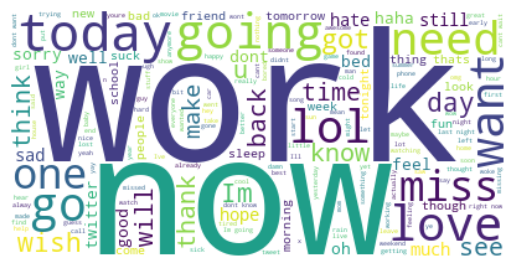

In [59]:
from wordcloud import WordCloud

text = ' '.join(df['review'])
wordcloud = WordCloud(background_color="white", max_words=2000,  contour_width=3, contour_color='steelblue').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('WordCloud.png')

In [ ]:
def stemming(text:str):
    port = nltk.PorterStemmer()
    text = ' '.join([port.stem(wd) for wd in text.split()])
    return text

train['review'] = train['review'].apply(stemming)
test['review'] = test['review'].apply(stemming)

In [ ]:
train['review']

0                   tommcfli see some funni video on youtub
1                              conversee on foot xd so cute
2         made taco for dinner now a frosti and twilight...
3         itsmeduh woop doin it real big i see have more...
4         georgieboo it wa a littl while ago but wossi a...
                                ...                        
397715    time to sleep sadli the man i want to have in ...
397716    i need a nap but i dont like take nap alon im ...
397717    india lost it again i need not be disappoint a...
397718    in school all alon ct off for report write day...
397719     dougiemcfli katpoynt i love you lol i wishh haha
Name: review, Length: 397720, dtype: object

# Treinando por Bag Of Words e Table Frequency

In [ ]:
results = dict()

### Bag of Words

In [ ]:
cv = CountVectorizer(min_df=1,binary=False,ngram_range=(1,3))

cv_train = cv.fit_transform(train[ 'review'])
cv_test = cv.transform(test[ 'review'])

In [ ]:
cv_train.shape,cv_test.shape

((397720, 4321977), (650852, 4321977))

### Table Frequency

In [ ]:
tv = TfidfVectorizer(min_df=1,use_idf=True,ngram_range=(1,3))

tv_train = tv.fit_transform(train['review'])
tv_test = tv.transform(test['review'])

In [ ]:
tv_train.shape,tv_test.shape

((397720, 4321977), (650852, 4321977))

# 1 - Modelo Logistic Regression

In [ ]:
lr =LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)

lr_bow = lr.fit(cv_train,train['sentiment'])
lr_tv = lr.fit(tv_train,train['sentiment'])
print(lr_bow)
print(lr_tv)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


In [ ]:
lr_bow_predict = lr_bow.predict(cv_test)
print(lr_bow_predict)

lr_tf_predict = lr_tv.predict(tv_test)
print(lr_tf_predict)

[0 0 1 ... 0 1 0]
[0 1 1 ... 0 1 0]


In [ ]:
results['Logistic Regression'] = {
    'Bag Of Words' : {
        'acc': accuracy_score(test['sentiment'],lr_bow_predict),
        'precision': precision_score(test['sentiment'],lr_bow_predict),
        'recal': recall_score(test['sentiment'],lr_bow_predict),
        'f1_score': f1_score(test['sentiment'],lr_bow_predict)
    },
    'Table Frequency' : {
        'acc': accuracy_score(test['sentiment'],lr_tf_predict),
        'precision': precision_score(test['sentiment'],lr_tf_predict),
        'recal': recall_score(test['sentiment'],lr_tf_predict),
        'f1_score': f1_score(test['sentiment'],lr_tf_predict)
    }
}

In [ ]:
lr_bow_acc = accuracy_score(test['sentiment'],lr_bow_predict)
print("Bag Of Words = ",lr_bow_acc)
lr_tf_acc = accuracy_score(test['sentiment'],lr_tf_predict)
print("Table = ",lr_tf_acc )

Bag Of Words =  0.876592527947982
Table =  0.826123296847824


In [ ]:
lr_trdf_report = classification_report(test['sentiment'],lr_bow_predict,target_names=['Positive','Negative'])
print(type(lr_trdf_report))

<class 'str'>


[[538520  62616]
 [ 17704  32012]]
[[498483 102653]
 [ 10515  39201]]


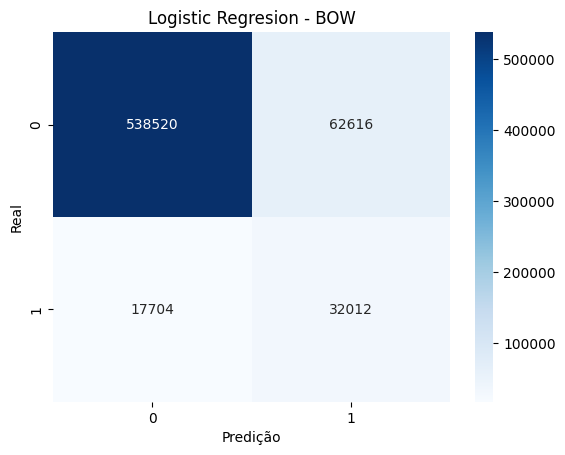

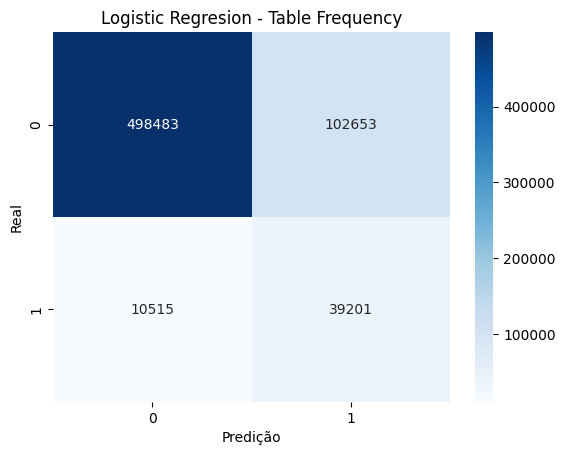

In [ ]:
cm_bow = confusion_matrix(test['sentiment'],lr_bow_predict,labels=[0,1])
print(cm_bow)
tf_bow = confusion_matrix(test['sentiment'],lr_tf_predict,labels=[0,1])
print(tf_bow)

sns.heatmap(cm_bow,annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predição")
plt.ylabel("Real")
plt.title("Logistic Regresion - BOW")
plt.savefig('Logistic_Regresion_BOW.png')
plt.show()

sns.heatmap(tf_bow,annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predição")
plt.ylabel("Real")
plt.title("Logistic Regresion - Table Frequency")
plt.savefig('Logistic_Regresion_TFID.png')
plt.show()

## Stochastic Gradient Descent

In [ ]:
svm = SGDClassifier(loss='hinge',max_iter=500,random_state=42)

svm_bow = svm.fit(cv_train,train['sentiment'])
svm_tv = svm.fit(tv_train,train['sentiment'])
print(svm_bow)
print(svm_tv)

SGDClassifier(max_iter=500, random_state=42)
SGDClassifier(max_iter=500, random_state=42)


In [ ]:
svm_bow_predict = svm_bow.predict(cv_test)
print(svm_bow_predict)

svm_tf_predict = svm_tv.predict(tv_test)
print(svm_tf_predict)

[0 0 1 ... 0 1 0]
[0 1 1 ... 0 1 0]


In [ ]:
results['SVM'] = {
    'Bag Of Words' : {
        'acc': accuracy_score(test['sentiment'],svm_bow_predict),
        'precision': precision_score(test['sentiment'],svm_bow_predict),
        'recal': recall_score(test['sentiment'],svm_bow_predict),
        'f1_score': f1_score(test['sentiment'],svm_bow_predict)
    },
    'Table Frequency' : {
        'acc': accuracy_score(test['sentiment'],svm_tf_predict),
        'precision': precision_score(test['sentiment'],svm_tf_predict),
        'recal': recall_score(test['sentiment'],svm_tf_predict),
        'f1_score': f1_score(test['sentiment'],svm_tf_predict)
    }
}

In [ ]:
svm_bow_acc = accuracy_score(test['sentiment'],svm_bow_predict)
print("Bag Of Words = ",svm_bow_acc)
svm_tf_acc = accuracy_score(test['sentiment'],svm_tf_predict)
print("Table = ",svm_tf_acc )

Bag Of Words =  0.8633375944147057
Table =  0.7901873236926368


In [ ]:
svm_trdf_report = classification_report(test['sentiment'],svm_bow_predict,target_names=['Positive','Negative'])
print(svm_trdf_report)

              precision    recall  f1-score   support

    Positive       0.96      0.89      0.92    601136
    Negative       0.29      0.54      0.38     49716

    accuracy                           0.86    650852
   macro avg       0.62      0.72      0.65    650852
weighted avg       0.91      0.86      0.88    650852



[[535004  66132]
 [ 22815  26901]]
[[477191 123945]
 [ 12612  37104]]


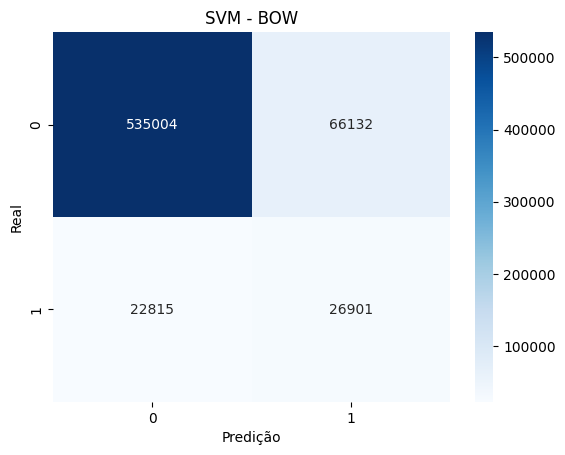

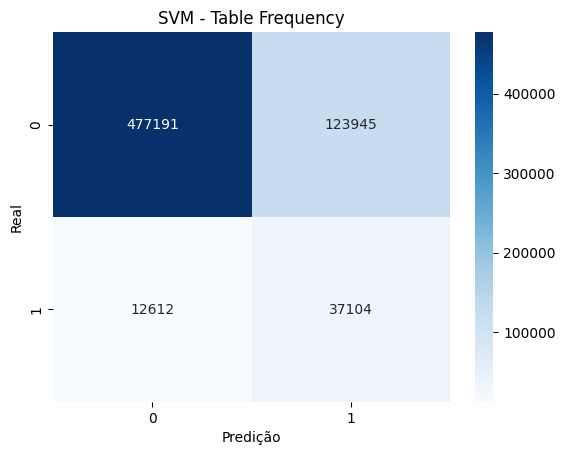

In [ ]:
cm_bow = confusion_matrix(test['sentiment'],svm_bow_predict,labels=[0,1])
print(cm_bow)
tf_bow = confusion_matrix(test['sentiment'],svm_tf_predict,labels=[0,1])
print(tf_bow)

sns.heatmap(cm_bow,annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predição")
plt.ylabel("Real")
plt.title("SVM - BOW")
plt.savefig('SVM_BOW.png')
plt.show()

sns.heatmap(tf_bow,annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predição")
plt.ylabel("Real")
plt.title("SVM - Table Frequency")
plt.savefig('SVM_TFID.png')
plt.show()

# Naive Bayes

In [ ]:
mvb = MultinomialNB()

mvb_bow = mvb.fit(cv_train, train['sentiment'])
mvb_tf = mvb.fit(tv_train, train['sentiment'])

In [ ]:
mvb_bow_predict = mvb_bow.predict(cv_test)
print(mvb_bow_predict)

mvb_tf_predict = mvb_tf.predict(tv_test)
print(mvb_tf_predict)

[0 1 1 ... 0 1 0]
[0 1 1 ... 0 1 0]


In [ ]:
results['Naive Bayes'] = {
    'Bag Of Words' : {
        'acc': accuracy_score(test['sentiment'],mvb_bow_predict),
        'precision': precision_score(test['sentiment'],mvb_bow_predict),
        'recal': recall_score(test['sentiment'],mvb_bow_predict),
        'f1_score': f1_score(test['sentiment'],mvb_bow_predict)
    },
    'Table Frequency' : {
        'acc': accuracy_score(test['sentiment'],mvb_tf_predict),
        'precision': precision_score(test['sentiment'],mvb_tf_predict),
        'recal': recall_score(test['sentiment'],mvb_tf_predict),
        'f1_score': f1_score(test['sentiment'],mvb_tf_predict)
    }
}

In [ ]:
mvb_bow_acc = accuracy_score(test['sentiment'],mvb_bow_predict)
print("Bag Of Words = ",mvb_bow_acc)
mvb_tf_acc = accuracy_score(test['sentiment'],mvb_tf_predict)
print("Table = ",mvb_tf_acc )

Bag Of Words =  0.8625447874478376
Table =  0.8525886069336808


[[526288  74848]
 [ 14615  35101]]
[[518537  82599]
 [ 13344  36372]]


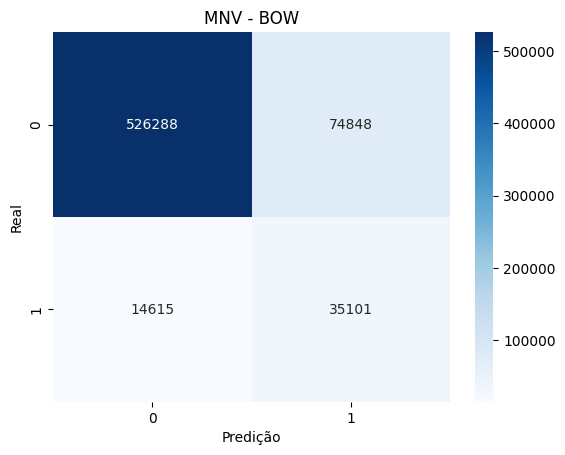

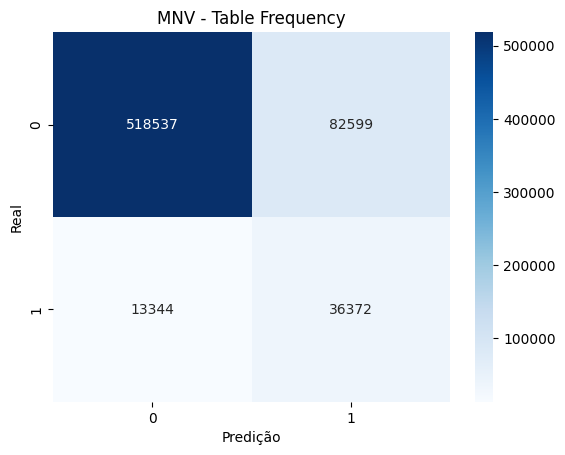

In [ ]:
cm_bow = confusion_matrix(test['sentiment'],mvb_bow_predict,labels=[0,1])
print(cm_bow)
tf_bow = confusion_matrix(test['sentiment'],mvb_tf_predict,labels=[0,1])
print(tf_bow)

sns.heatmap(cm_bow,annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predição")
plt.ylabel("Real")
plt.title("MNV - BOW")
plt.savefig('MNV_BOW.png')
plt.show()

sns.heatmap(tf_bow,annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predição")
plt.ylabel("Real")
plt.title("MNV - Table Frequency")
plt.savefig('MNV_TFID.png')
plt.show()

In [ ]:
import json

with open('results.json', 'w') as file:
     file.write(json.dumps(results))